In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import time
import os
from itertools import product
from pylab import rcParams
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_log_error
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess, Fourier

## NOW FOR LOADING THE DATA


In [2]:
oil= pd.read_csv('oil.csv')
holidays_events=pd.read_csv('holidays_events.csv')
stores= pd.read_csv('stores.csv')
train= pd.read_csv('train.csv')
test= pd.read_csv('test.csv')
transactions= pd.read_csv('transactions.csv')

In [3]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


## DATA MANUPILATION

## Creation of calender from 2013 to 2017 August 31st

## Moving Average for Oil

## Creating a variable day of the week

## Correction of Holiday event data

## Calender and Moving average

In [4]:
calendar = pd.DataFrame(index=pd.date_range('2013-01-01', '2017-08-31'))

# moving average
df_oil = pd.read_csv('oil.csv', parse_dates=['date'], infer_datetime_format=True, index_col='date')
df_oil['ma_oil'] = df_oil['dcoilwtico'].rolling(7).mean()

calendar = calendar.merge(df_oil, how='left', left_index=True, right_index=True)
calendar['ma_oil'].fillna(method='ffill', inplace=True)

### Day of week


In [5]:
calendar['dofw'] = calendar.index.dayofweek


### Holiday Events

In [6]:
df_events = pd.read_csv('holidays_events.csv', parse_dates=['date'], infer_datetime_format=True)
df_events['date'] = df_events['date']
df_events = df_events.set_index('date').sort_index()
df_events = df_events[df_events.locale == 'National'] 
df_events = df_events.groupby(df_events.index).first() # Keep one event only

## Work days inclusion on calender

In [7]:
calendar['wd'] = True

calendar.loc[calendar.dofw > 4, 'wd'] = False
calendar = calendar.merge(df_events, how='left', left_index=True, right_index=True)
calendar.loc[calendar.type == 'Bridge'  , 'wd'] = False
calendar.loc[calendar.type == 'Work Day', 'wd'] = True
calendar.loc[calendar.type == 'Transfer', 'wd'] = False
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == False), 'wd'] = False
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == True ), 'wd'] = True

## MODELING THE DATA
### Ridge Regression

In [8]:
df_train = pd.read_csv('train.csv',
                       usecols=['store_nbr', 'family', 'date', 'sales'],
                       dtype={'store_nbr': 'category', 'family': 'category', 'sales': 'float32'},
                       parse_dates=['date'], infer_datetime_format=True)
df_train.date = df_train.date.dt.to_period('D')
df_train = df_train.set_index(['store_nbr', 'family', 'date']).sort_index()

df_test = pd.read_csv('test.csv',
                      usecols=['store_nbr', 'family', 'date'],
                      dtype={'store_nbr': 'category', 'family': 'category'},
                      parse_dates=['date'], infer_datetime_format=True)
df_test.date = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

In [9]:
end_date='2017-08-15'
start_date='2017-04-01'

In [10]:
y = df_train.unstack(['store_nbr', 'family']).loc[start_date:end_date]

fourier = CalendarFourier(freq='W', order=4)
dp = DeterministicProcess(index=y.index,
                          constant=False,
                          order=1,
                          seasonal=False,
                          additional_terms=[fourier],
                          drop=True)
X = dp.in_sample()

# Extentions

X['oil']  = calendar.loc[start_date:end_date]['ma_oil'].values
X['dofw'] = calendar.loc[start_date:end_date]['dofw'].values
X['wd']   = calendar.loc[start_date:end_date]['wd'].values
X['type'] = calendar.loc[start_date:end_date]['type'].values

X = pd.get_dummies(X, columns=['dofw'], drop_first=True)
X = pd.get_dummies(X, columns=['type'], drop_first=False)

model = Ridge(fit_intercept=True, solver='auto', alpha=0.5, normalize=True) # try alpha,0.1 ,0.3 ,0.6 and 0.9
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  FutureWarning,


## Printing the results of the model¶


In [11]:
y_pred   = y_pred.stack(['store_nbr', 'family']).reset_index()
y_target = y.stack(['store_nbr', 'family']).reset_index().copy()
y_target['sales_pred'] = y_pred['sales'].clip(0.) 
y_target.groupby('family').apply(lambda r: mean_squared_log_error(r['sales'], r['sales_pred']))

family
AUTOMOTIVE                    0.259202
BABY CARE                     0.066660
BEAUTY                        0.267450
BEVERAGES                     0.199187
BOOKS                         0.026701
BREAD/BAKERY                  0.125449
CELEBRATION                   0.295910
CLEANING                      0.204513
DAIRY                         0.136196
DELI                          0.108830
EGGS                          0.147672
FROZEN FOODS                  0.145027
GROCERY I                     0.210306
GROCERY II                    0.347753
HARDWARE                      0.273930
HOME AND KITCHEN I            0.259483
HOME AND KITCHEN II           0.219104
HOME APPLIANCES               0.154737
HOME CARE                     0.122103
LADIESWEAR                    0.259483
LAWN AND GARDEN               0.216374
LINGERIE                      0.400216
LIQUOR,WINE,BEER              0.612719
MAGAZINES                     0.254086
MEATS                         0.123141
PERSONAL CARE     

# Ploting the sales of School and Office Supplies from 2014

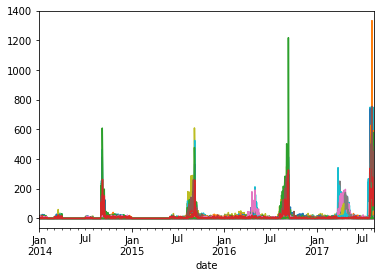

In [12]:
df_train.unstack(['store_nbr', 'family']).loc['2014':].loc(axis=1)['sales', :, 'SCHOOL AND OFFICE SUPPLIES'].plot(legend=None)

The Schools and Office supplies category seems to be a bit to noisy for linear regression, hence lets take the Randomforest Model approach

# RandomForest and Ridge Regression

In [13]:
from joblib import Parallel, delayed
import warnings

from sklearn.linear_model import Ridge
from sklearn.ensemble     import RandomForestRegressor

class CustomRegressor():
    
    def __init__(self, n_jobs=-1, verbose=0):
        
        self.n_jobs = n_jobs
        self.verbose = verbose
        
        self.estimators_ = None
        
    def _estimator_(self, X, y):
    
        warnings.simplefilter(action='ignore', category=FutureWarning)
        
        if y.name[2] == 'SCHOOL AND OFFICE SUPPLIES':
            
            model = RandomForestRegressor(n_estimators = 300, n_jobs=-1, random_state=1)
            
        else:
            
            model = Ridge(fit_intercept=True, solver='auto', alpha=0.5, normalize=True)
            
        model.fit(X, y)

        return model

    def fit(self, X, y):

        self.estimators_ = Parallel(n_jobs=self.n_jobs, 
                              verbose=self.verbose,
                              )(delayed(self._estimator_)(X, y.iloc[:, i]) for i in range(y.shape[1]))
        
        return
    
    def predict(self, X):
        
        y_pred = Parallel(n_jobs=self.n_jobs, 
                          verbose=self.verbose)(delayed(e.predict)(X) for e in self.estimators_)
        
        return np.stack(y_pred, axis=1)

In [14]:
model = CustomRegressor(n_jobs=-1, verbose=0)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

# RandomForest Model results

In [15]:
y_pred   = y_pred.stack(['store_nbr', 'family']).reset_index()
y_target = y.stack(['store_nbr', 'family']).reset_index().copy()
y_target['sales_pred'] = y_pred['sales'].clip(0.) 
y_target.groupby('family').apply(lambda r: mean_squared_log_error(r['sales'], r['sales_pred']))

family
AUTOMOTIVE                    0.259202
BABY CARE                     0.066660
BEAUTY                        0.267450
BEVERAGES                     0.199187
BOOKS                         0.026701
BREAD/BAKERY                  0.125449
CELEBRATION                   0.295910
CLEANING                      0.204513
DAIRY                         0.136196
DELI                          0.108830
EGGS                          0.147672
FROZEN FOODS                  0.145027
GROCERY I                     0.210306
GROCERY II                    0.347753
HARDWARE                      0.273930
HOME AND KITCHEN I            0.259483
HOME AND KITCHEN II           0.219104
HOME APPLIANCES               0.154737
HOME CARE                     0.122103
LADIESWEAR                    0.259483
LAWN AND GARDEN               0.216374
LINGERIE                      0.400216
LIQUOR,WINE,BEER              0.612719
MAGAZINES                     0.254086
MEATS                         0.123141
PERSONAL CARE     

# TEST THE PREDICTIONS

In [16]:
end_test='2017-08-31'
start_test='2017-08-16'
X_test = dp.out_of_sample(steps=16)

# Extentions
X_test['oil']  = calendar.loc[start_test:end_test]['ma_oil'].values
X_test['dofw'] = calendar.loc[start_test:end_test]['dofw'].values
X_test['wd']   = calendar.loc[start_test:end_test]['wd'].values

X_test = pd.get_dummies(X_test, columns=['dofw'], drop_first=True)

# No national level events in this period
X_test[['type_Additional', 'type_Event', 'type_Holiday', 'type_Transfer']] = 0

sales_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
sales_pred = sales_pred.stack(['store_nbr', 'family'])
sales_pred[sales_pred < 0] = 0. 

# Create a Submission¶


In [22]:
My_submission = pd.read_csv('sample_submission.csv', index_col='id')
My_submission.sales = sales_pred.values
My_submission.to_csv('submission.csv', index=True)

In [23]:
My_submission

,sales
id,
3000888,4.309557
3000889,0.000000
3000890,3.998301
3000891,2417.365382
3000892,0.482959
...,...
3029395,336.982537
3029396,93.747146
3029397,1267.738442


In [24]:
oil= pd.read_csv('oil.csv')
holidays_events=pd.read_csv('holidays_events.csv')
stores= pd.read_csv('stores.csv')
train= pd.read_csv('train.csv')
test= pd.read_csv('test.csv')
transactions= pd.read_csv('transactions.csv')


In [25]:


big_train=pd.merge(train,oil, on="date" )
big_train

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0.0,NaN
1,1,2013-01-01,1,BABY CARE,0.000,0.0,NaN
2,2,2013-01-01,1,BEAUTY,0.000,0.0,NaN
3,3,2013-01-01,1,BEVERAGES,0.000,0.0,NaN
4,4,2013-01-01,1,BOOKS,0.000,0.0,NaN
...,...,...,...,...,...,...,...
2143741,3000883,2017-08-15,9,POULTRY,438.133,15.0,47.57
2143742,3000884,2017-08-15,9,PREPARED FOODS,154.553,8.0,47.57
2143743,3000885,2017-08-15,9,PRODUCE,2419.729,148.0,47.57
2143744,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,10.0,47.57


In [26]:
big_train=pd.merge(big_train,holidays_events, on="date")
big_train

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,type,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0.0,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.000,0.0,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.000,0.0,NaN,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.000,0.0,NaN,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.000,0.0,NaN,Holiday,National,Ecuador,Primer dia del ano,False
...,...,...,...,...,...,...,...,...,...,...,...,...
352831,3000883,2017-08-15,9,POULTRY,438.133,15.0,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False
352832,3000884,2017-08-15,9,PREPARED FOODS,154.553,8.0,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False
352833,3000885,2017-08-15,9,PRODUCE,2419.729,148.0,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False
352834,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,10.0,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False


In [27]:
big_train=pd.merge(big_train,stores, on="store_nbr")
big_train

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,type_x,locale,locale_name,description,transferred,city,state,type_y,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0.0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.000,0.0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.000,0.0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.000,0.0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.000,0.0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352831,3000883,2017-08-15,9,POULTRY,438.133,15.0,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,Quito,Pichincha,B,6
352832,3000884,2017-08-15,9,PREPARED FOODS,154.553,8.0,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,Quito,Pichincha,B,6
352833,3000885,2017-08-15,9,PRODUCE,2419.729,148.0,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,Quito,Pichincha,B,6
352834,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,10.0,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,Quito,Pichincha,B,6


In [28]:
transactions[transactions["date"]=="2013-01-01"]


,date,store_nbr,transactions
0,2013-01-01,25,770


In [29]:
big_train=pd.merge(big_train,transactions, on=["store_nbr","date"])
big_train

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,type_x,locale,locale_name,description,transferred,city,state,type_y,cluster,transactions
0,73062,2013-02-11,1,AUTOMOTIVE,0.000,0.0,97.01,Holiday,National,Ecuador,Carnaval,False,Quito,Pichincha,D,13,396
1,73063,2013-02-11,1,BABY CARE,0.000,0.0,97.01,Holiday,National,Ecuador,Carnaval,False,Quito,Pichincha,D,13,396
2,73064,2013-02-11,1,BEAUTY,0.000,0.0,97.01,Holiday,National,Ecuador,Carnaval,False,Quito,Pichincha,D,13,396
3,73065,2013-02-11,1,BEVERAGES,172.000,0.0,97.01,Holiday,National,Ecuador,Carnaval,False,Quito,Pichincha,D,13,396
4,73066,2013-02-11,1,BOOKS,0.000,0.0,97.01,Holiday,National,Ecuador,Carnaval,False,Quito,Pichincha,D,13,396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322042,3000883,2017-08-15,9,POULTRY,438.133,15.0,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,Quito,Pichincha,B,6,2155
322043,3000884,2017-08-15,9,PREPARED FOODS,154.553,8.0,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,Quito,Pichincha,B,6,2155
322044,3000885,2017-08-15,9,PRODUCE,2419.729,148.0,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,Quito,Pichincha,B,6,2155
322045,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,10.0,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,Quito,Pichincha,B,6,2155


In [30]:
import scipy
from scipy import stats
scipy.stats.pearsonr(big_train["sales"], big_train["onpromotion"])

(0.7499479547305623, 0.0)

In [31]:
scipy.stats.pearsonr(big_train["sales"], big_train["store_nbr"])


(0.05134879846310603, 6.396452029703027e-187)

In [32]:
df_locale = pd.get_dummies(big_train['locale'])
big_train = pd.concat([big_train, df_locale], axis=1)
big_train.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,type_x,locale,locale_name,description,transferred,city,state,type_y,cluster,transactions,Local,National,Regional
0,73062,2013-02-11,1,AUTOMOTIVE,0.0,0.0,97.01,Holiday,National,Ecuador,Carnaval,False,Quito,Pichincha,D,13,396,0,1,0
1,73063,2013-02-11,1,BABY CARE,0.0,0.0,97.01,Holiday,National,Ecuador,Carnaval,False,Quito,Pichincha,D,13,396,0,1,0
2,73064,2013-02-11,1,BEAUTY,0.0,0.0,97.01,Holiday,National,Ecuador,Carnaval,False,Quito,Pichincha,D,13,396,0,1,0
3,73065,2013-02-11,1,BEVERAGES,172.0,0.0,97.01,Holiday,National,Ecuador,Carnaval,False,Quito,Pichincha,D,13,396,0,1,0
4,73066,2013-02-11,1,BOOKS,0.0,0.0,97.01,Holiday,National,Ecuador,Carnaval,False,Quito,Pichincha,D,13,396,0,1,0


In [33]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
LR = LinearRegression()
X=big_train[["onpromotion", 'transactions']]
Y=big_train["sales"]

model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)


                                 OLS Regression Results                                
Dep. Variable:                  sales   R-squared (uncentered):                   0.614
Model:                            OLS   Adj. R-squared (uncentered):              0.614
Method:                 Least Squares   F-statistic:                          2.558e+05
Date:                Sun, 14 Nov 2021   Prob (F-statistic):                        0.00
Time:                        17:41:49   Log-Likelihood:                     -2.6158e+06
No. Observations:              322047   AIC:                                  5.232e+06
Df Residuals:                  322045   BIC:                                  5.232e+06
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [34]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
LR = LinearRegression()
X=big_train[["onpromotion", 'transactions']]
Y=big_train["sales"]

model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)
print(predictions)

                                 OLS Regression Results                                
Dep. Variable:                  sales   R-squared (uncentered):                   0.614
Model:                            OLS   Adj. R-squared (uncentered):              0.614
Method:                 Least Squares   F-statistic:                          2.558e+05
Date:                Sun, 14 Nov 2021   Prob (F-statistic):                        0.00
Time:                        17:41:55   Log-Likelihood:                     -2.6158e+06
No. Observations:              322047   AIC:                                  5.232e+06
Df Residuals:                  322045   BIC:                                  5.232e+06
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [35]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
LR = LinearRegression()
X=big_train["onpromotion"]
Y=big_train["sales"]
Xnew=test["onpromotion"]
model = sm.OLS(Y, X).fit()
predictions = model.predict(Xnew) 
 
print_model = model.summary()

print(predictions)

0         175.515615
1           8.775781
2          70.206246
3        4914.437221
4           8.775781
            ...     
28507     473.892161
28508      87.757808
28509    2650.285787
28510     131.636711
28511      70.206246
Length: 28512, dtype: float64


In [36]:
headerList = ["id", "sales"]

predictions.index = np.arange(3000888, 3000888+len(predictions))
predictions.index.name = 'id'

In [37]:
predictions.to_csv("submission3.csv", header=["sales"], index=True)


In [38]:
pd.read_csv("submission3.csv")


,id,sales
0,3000888,175.515615
1,3000889,8.775781
2,3000890,70.206246
3,3000891,4914.437221
4,3000892,8.775781
...,...,...
28507,3029395,473.892161
28508,3029396,87.757808
28509,3029397,2650.285787
28510,3029398,131.636711
